In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from model import Net
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
! pip install torchsummary
from torchsummary import summary

%matplotlib inline

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)), 
                                       transforms.ColorJitter(brightness=0.40, contrast=0.4, saturation=0.40, hue=0.1),
                                       transforms.RandomAffine(degrees=7, shear=10, translate=(0.1, 0.1), scale=(0.8, 1.2)),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()


use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [5]:


train_losses = []
test_losses = []
train_acc = []
test_acc = []

lambda_1 = 0.01


# L1 Norm
def train(model, device, train_loader, optimizer, epoch, L1=False):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)

    # if using L1 regularization
    l1 = 1 if L1 else 0

    if l1:
      for p in model.parameters():
        l1 += torch.norm(p)

    loss += lambda_1 * l1
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))


In [7]:
norm_options = ["BN", "GN", "LN"]

metrics = {}

for norm in norm_options:
  model = Net(norm).to(device)
  print(f"Norm Type - { norm }")

  # print summary for norm type
  summary(model, input_size=(1, 28, 28))

  train_losses = []
  test_losses = []
  train_acc = []
  test_acc = []

  lambda_1 = 0.01

  EPOCHS = 15

  model =  Net(norm).to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  scheduler = StepLR(optimizer, step_size=8, gamma=0.1)

  
  for epoch in range(EPOCHS):
      print("EPOCH:", epoch)

      # use L1 if norm is BN
      L1 = 1 if norm == "BN" else 0

      train(model, device, train_loader, optimizer, epoch, L1=L1)
      scheduler.step()
      test(model, device, test_loader)
  

  metrics[norm] = [train_losses, test_losses, train_acc, test_acc]


Norm Type - BN
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           2,304
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 16, 24, 24]             256
        MaxPool2d-10           [-1, 16, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           2,304
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14    

  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.566280722618103 Batch_id=468 Accuracy=76.84: 100%|██████████| 469/469 [00:55<00:00,  8.38it/s]



Test set: Average loss: 0.0936, Accuracy: 9732/10000 (97.32%)

EPOCH: 1


Loss=0.6192325353622437 Batch_id=468 Accuracy=95.39: 100%|██████████| 469/469 [00:55<00:00,  8.42it/s]



Test set: Average loss: 0.0711, Accuracy: 9803/10000 (98.03%)

EPOCH: 2


Loss=0.508406937122345 Batch_id=468 Accuracy=96.28: 100%|██████████| 469/469 [00:55<00:00,  8.47it/s]



Test set: Average loss: 0.0586, Accuracy: 9821/10000 (98.21%)

EPOCH: 3


Loss=0.5547385215759277 Batch_id=468 Accuracy=96.54: 100%|██████████| 469/469 [00:55<00:00,  8.44it/s]



Test set: Average loss: 0.0474, Accuracy: 9860/10000 (98.60%)

EPOCH: 4


Loss=0.6288698315620422 Batch_id=468 Accuracy=96.81: 100%|██████████| 469/469 [00:55<00:00,  8.46it/s]



Test set: Average loss: 0.0395, Accuracy: 9877/10000 (98.77%)

EPOCH: 5


Loss=0.43778544664382935 Batch_id=468 Accuracy=97.01: 100%|██████████| 469/469 [00:54<00:00,  8.54it/s]



Test set: Average loss: 0.0478, Accuracy: 9844/10000 (98.44%)

EPOCH: 6


Loss=0.3472343981266022 Batch_id=468 Accuracy=96.97: 100%|██████████| 469/469 [00:55<00:00,  8.43it/s]



Test set: Average loss: 0.0481, Accuracy: 9856/10000 (98.56%)

EPOCH: 7


Loss=0.3842426836490631 Batch_id=468 Accuracy=96.97: 100%|██████████| 469/469 [00:55<00:00,  8.44it/s]



Test set: Average loss: 0.0382, Accuracy: 9878/10000 (98.78%)

EPOCH: 8


Loss=0.3909488916397095 Batch_id=468 Accuracy=97.84: 100%|██████████| 469/469 [00:55<00:00,  8.43it/s]



Test set: Average loss: 0.0244, Accuracy: 9925/10000 (99.25%)

EPOCH: 9


Loss=0.31512030959129333 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:55<00:00,  8.39it/s]



Test set: Average loss: 0.0232, Accuracy: 9930/10000 (99.30%)

EPOCH: 10


Loss=0.32106906175613403 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:55<00:00,  8.39it/s]



Test set: Average loss: 0.0230, Accuracy: 9929/10000 (99.29%)

EPOCH: 11


Loss=0.2971549332141876 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:55<00:00,  8.47it/s]



Test set: Average loss: 0.0223, Accuracy: 9934/10000 (99.34%)

EPOCH: 12


Loss=0.2974185645580292 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:55<00:00,  8.40it/s]



Test set: Average loss: 0.0237, Accuracy: 9928/10000 (99.28%)

EPOCH: 13


Loss=0.3405633866786957 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:55<00:00,  8.43it/s]



Test set: Average loss: 0.0247, Accuracy: 9930/10000 (99.30%)

EPOCH: 14


Loss=0.3573586046695709 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:55<00:00,  8.44it/s]



Test set: Average loss: 0.0231, Accuracy: 9929/10000 (99.29%)

Norm Type - GN
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
         GroupNorm-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           2,304
              ReLU-6           [-1, 16, 24, 24]               0
         GroupNorm-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 16, 24, 24]             256
        MaxPool2d-10           [-1, 16, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           2,304
             ReLU-12           [-1, 16, 10, 10]               0
        GroupNorm-13    

Loss=0.23207469284534454 Batch_id=468 Accuracy=68.56: 100%|██████████| 469/469 [00:54<00:00,  8.67it/s]



Test set: Average loss: 0.1205, Accuracy: 9692/10000 (96.92%)

EPOCH: 1


Loss=0.25186941027641296 Batch_id=468 Accuracy=95.23: 100%|██████████| 469/469 [00:53<00:00,  8.75it/s]



Test set: Average loss: 0.0488, Accuracy: 9868/10000 (98.68%)

EPOCH: 2


Loss=0.1282496601343155 Batch_id=468 Accuracy=96.52: 100%|██████████| 469/469 [00:53<00:00,  8.73it/s]



Test set: Average loss: 0.0515, Accuracy: 9857/10000 (98.57%)

EPOCH: 3


Loss=0.060088202357292175 Batch_id=468 Accuracy=97.30: 100%|██████████| 469/469 [00:53<00:00,  8.71it/s]



Test set: Average loss: 0.0334, Accuracy: 9891/10000 (98.91%)

EPOCH: 4


Loss=0.018171755596995354 Batch_id=468 Accuracy=97.56: 100%|██████████| 469/469 [00:54<00:00,  8.66it/s]



Test set: Average loss: 0.0319, Accuracy: 9902/10000 (99.02%)

EPOCH: 5


Loss=0.04852965474128723 Batch_id=468 Accuracy=97.69: 100%|██████████| 469/469 [00:53<00:00,  8.70it/s]



Test set: Average loss: 0.0348, Accuracy: 9892/10000 (98.92%)

EPOCH: 6


Loss=0.05759020522236824 Batch_id=468 Accuracy=97.88: 100%|██████████| 469/469 [00:54<00:00,  8.67it/s]



Test set: Average loss: 0.0291, Accuracy: 9911/10000 (99.11%)

EPOCH: 7


Loss=0.02940562181174755 Batch_id=468 Accuracy=97.91: 100%|██████████| 469/469 [00:53<00:00,  8.69it/s]



Test set: Average loss: 0.0219, Accuracy: 9929/10000 (99.29%)

EPOCH: 8


Loss=0.04908197000622749 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:54<00:00,  8.68it/s]



Test set: Average loss: 0.0201, Accuracy: 9936/10000 (99.36%)

EPOCH: 9


Loss=0.07408365607261658 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:54<00:00,  8.66it/s]



Test set: Average loss: 0.0203, Accuracy: 9933/10000 (99.33%)

EPOCH: 10


Loss=0.08617281913757324 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:54<00:00,  8.63it/s]



Test set: Average loss: 0.0204, Accuracy: 9941/10000 (99.41%)

EPOCH: 11


Loss=0.022699706256389618 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:54<00:00,  8.64it/s]



Test set: Average loss: 0.0202, Accuracy: 9943/10000 (99.43%)

EPOCH: 12


Loss=0.047419238835573196 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:53<00:00,  8.70it/s]



Test set: Average loss: 0.0198, Accuracy: 9943/10000 (99.43%)

EPOCH: 13


Loss=0.014406214468181133 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:53<00:00,  8.75it/s]



Test set: Average loss: 0.0202, Accuracy: 9938/10000 (99.38%)

EPOCH: 14


Loss=0.09633326530456543 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:53<00:00,  8.69it/s]



Test set: Average loss: 0.0203, Accuracy: 9937/10000 (99.37%)

Norm Type - LN
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
         LayerNorm-3           [-1, 16, 26, 26]          21,632
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           2,304
              ReLU-6           [-1, 16, 24, 24]               0
         LayerNorm-7           [-1, 16, 24, 24]          18,432
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 16, 24, 24]             256
        MaxPool2d-10           [-1, 16, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           2,304
             ReLU-12           [-1, 16, 10, 10]               0
        LayerNorm-13    

Loss=0.17218025028705597 Batch_id=468 Accuracy=74.73: 100%|██████████| 469/469 [00:53<00:00,  8.70it/s]



Test set: Average loss: 0.0998, Accuracy: 9759/10000 (97.59%)

EPOCH: 1


Loss=0.07048073410987854 Batch_id=468 Accuracy=95.66: 100%|██████████| 469/469 [00:53<00:00,  8.81it/s]



Test set: Average loss: 0.0485, Accuracy: 9874/10000 (98.74%)

EPOCH: 2


Loss=0.06669103354215622 Batch_id=468 Accuracy=96.97: 100%|██████████| 469/469 [00:53<00:00,  8.73it/s]



Test set: Average loss: 0.0453, Accuracy: 9860/10000 (98.60%)

EPOCH: 3


Loss=0.035165611654520035 Batch_id=468 Accuracy=97.33: 100%|██████████| 469/469 [00:53<00:00,  8.77it/s]



Test set: Average loss: 0.0281, Accuracy: 9920/10000 (99.20%)

EPOCH: 4


Loss=0.06513936072587967 Batch_id=468 Accuracy=97.69: 100%|██████████| 469/469 [00:54<00:00,  8.64it/s]



Test set: Average loss: 0.0266, Accuracy: 9915/10000 (99.15%)

EPOCH: 5


Loss=0.0571446567773819 Batch_id=468 Accuracy=97.88: 100%|██████████| 469/469 [00:53<00:00,  8.76it/s]



Test set: Average loss: 0.0252, Accuracy: 9923/10000 (99.23%)

EPOCH: 6


Loss=0.03645983710885048 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:53<00:00,  8.75it/s]



Test set: Average loss: 0.0229, Accuracy: 9931/10000 (99.31%)

EPOCH: 7


Loss=0.04712933674454689 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:53<00:00,  8.75it/s]



Test set: Average loss: 0.0223, Accuracy: 9927/10000 (99.27%)

EPOCH: 8


Loss=0.006859505083411932 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:53<00:00,  8.74it/s]



Test set: Average loss: 0.0183, Accuracy: 9944/10000 (99.44%)

EPOCH: 9


Loss=0.016629405319690704 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:53<00:00,  8.74it/s]



Test set: Average loss: 0.0183, Accuracy: 9946/10000 (99.46%)

EPOCH: 10


Loss=0.11514415591955185 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:53<00:00,  8.75it/s]



Test set: Average loss: 0.0182, Accuracy: 9948/10000 (99.48%)

EPOCH: 11


Loss=0.06914839893579483 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:53<00:00,  8.70it/s]



Test set: Average loss: 0.0188, Accuracy: 9948/10000 (99.48%)

EPOCH: 12


Loss=0.1593674123287201 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:53<00:00,  8.73it/s]



Test set: Average loss: 0.0175, Accuracy: 9953/10000 (99.53%)

EPOCH: 13


Loss=0.026353204622864723 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:53<00:00,  8.69it/s]



Test set: Average loss: 0.0175, Accuracy: 9947/10000 (99.47%)

EPOCH: 14


Loss=0.08926573395729065 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:54<00:00,  8.63it/s]



Test set: Average loss: 0.0172, Accuracy: 9950/10000 (99.50%)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


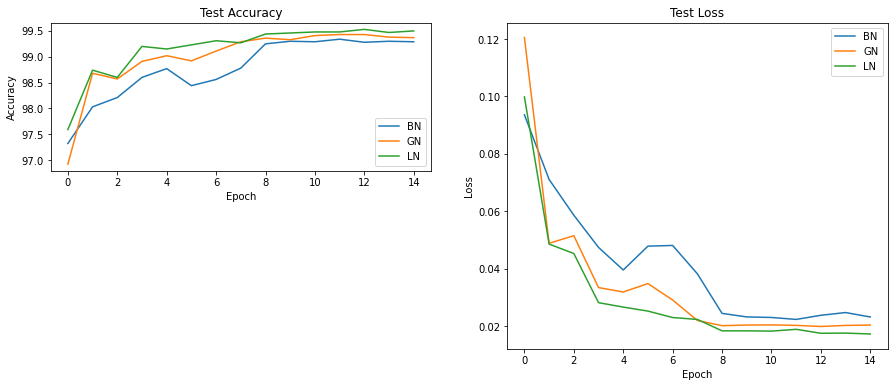

In [8]:


plt.rcParams['figure.figsize'] = [15, 6]

for norm in norm_options:
  train_losses = metrics[norm][0]
  test_losses = metrics[norm][1]
  train_acc = metrics[norm][2]
  test_acc = metrics[norm][3]

  plt.subplot(2,2, 1)

  plt.plot(test_acc)
  plt.legend(norm_options)
  plt.title("Test Accuracy")

  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')

  plt.subplot(1,2,2)
  plt.plot(test_losses)
  plt.legend(norm_options)
  plt.title('Test Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

--------------- BN --------------- 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


--------------- GN --------------- --------------- LN --------------- 

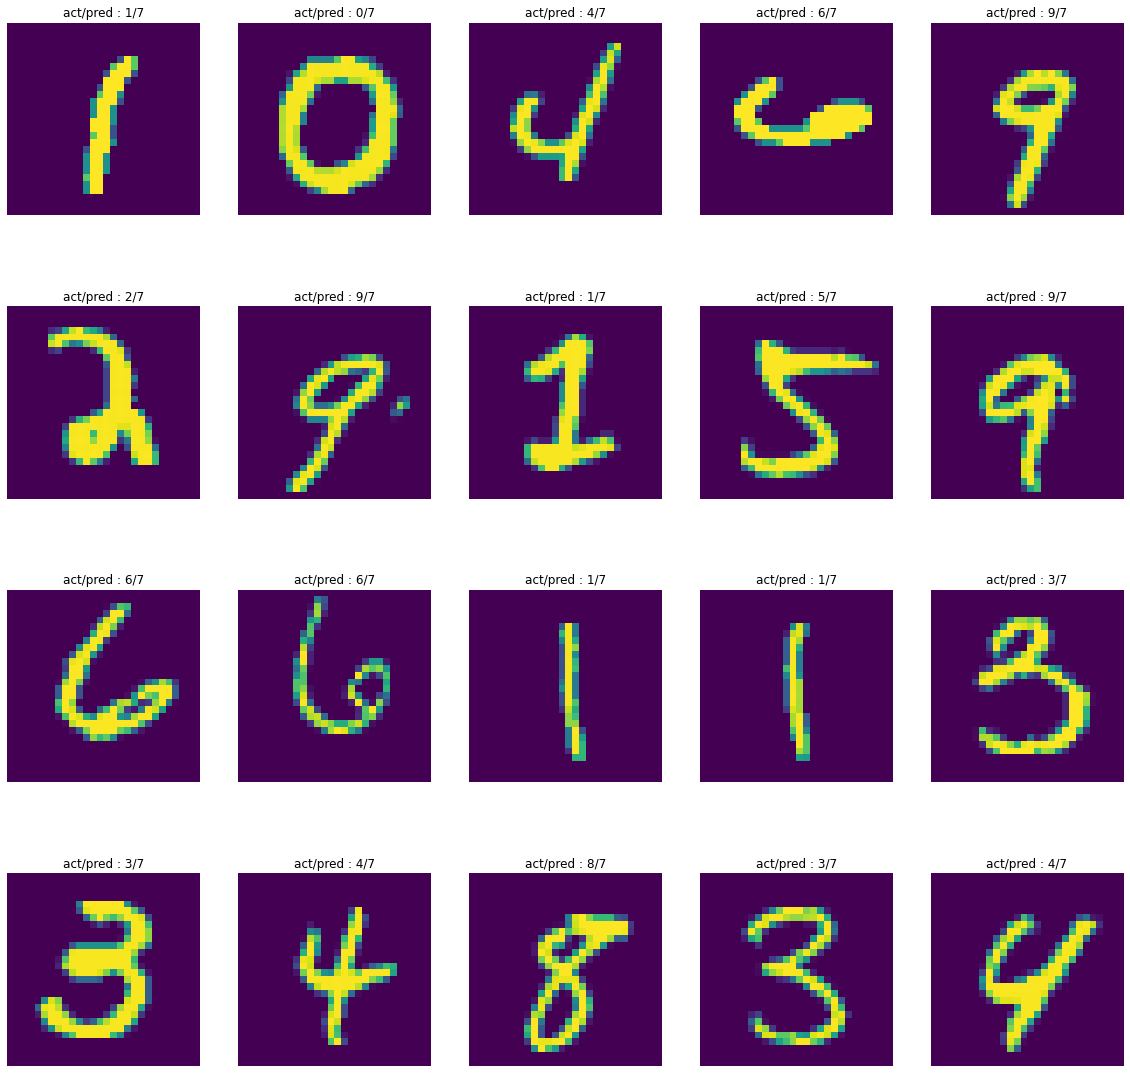

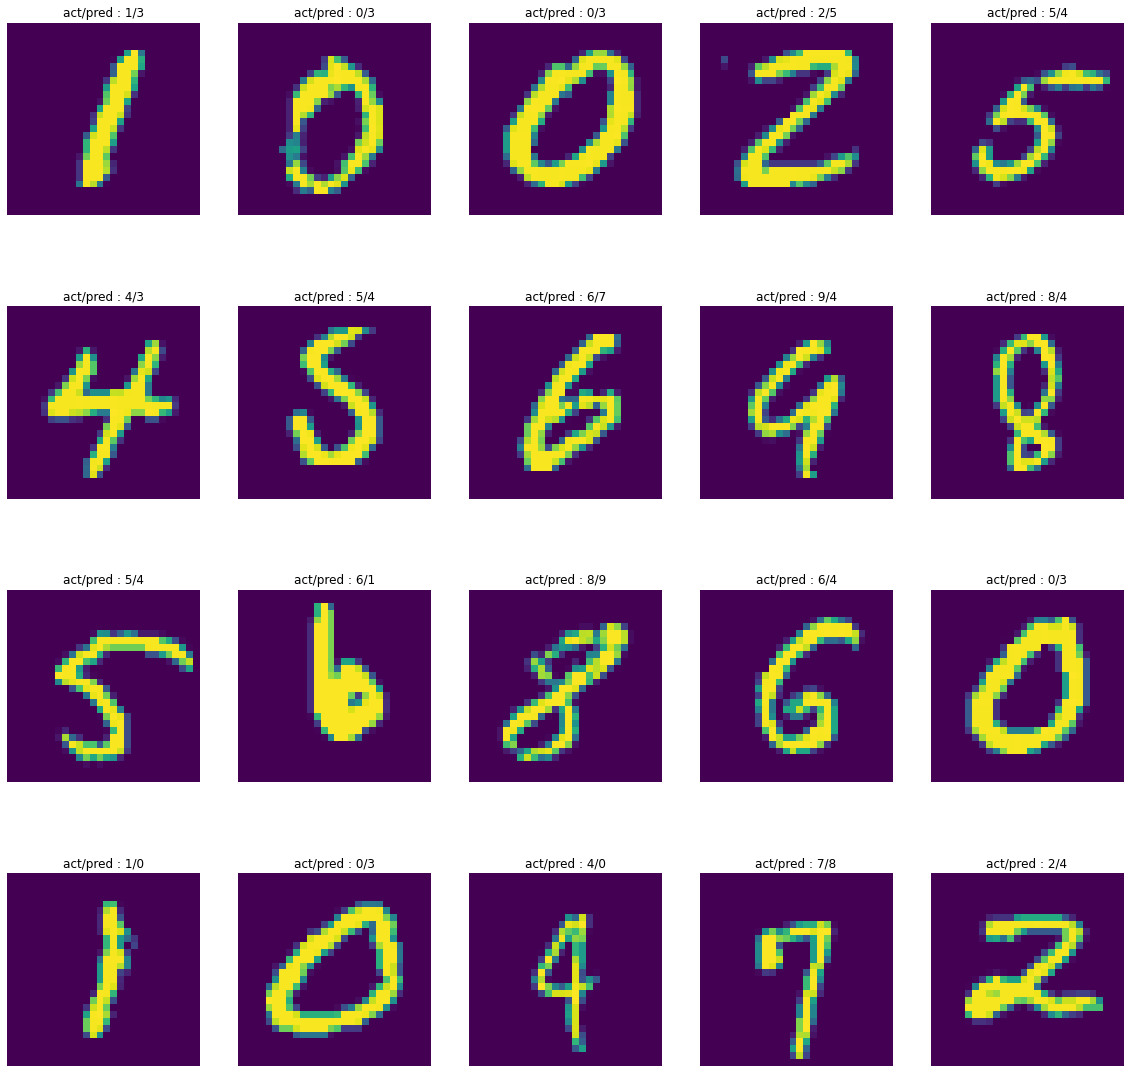

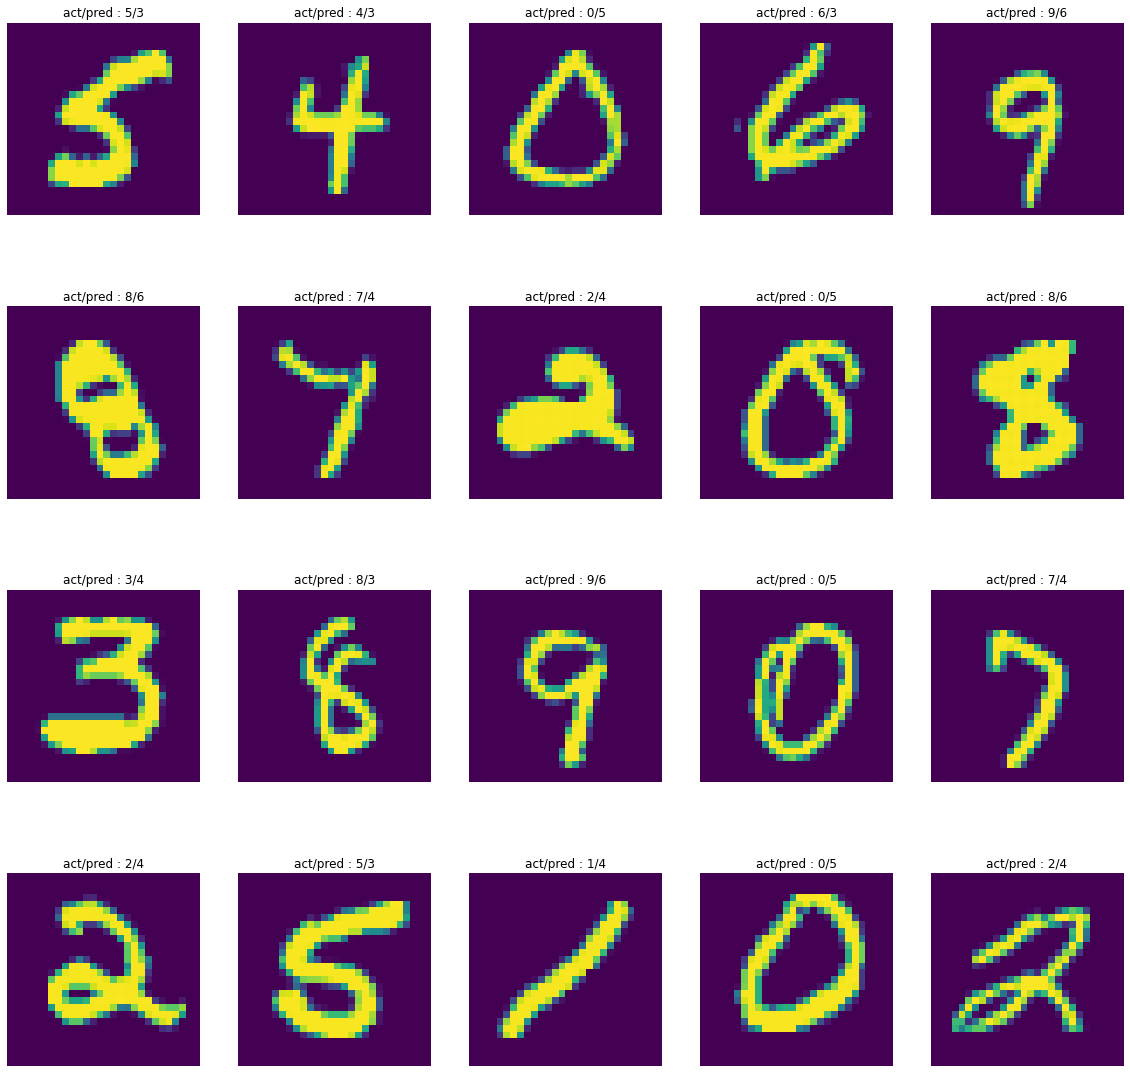

In [9]:
classes = ('0','1','2','3','4','5','6','7','8','9')

for norm in norm_options:

  print('-'*15,end=' ')
  print(norm,end=' ')
  print('-'*15,end = ' ')

  model = Net(norm).to(device)

  model.eval()

  figure = plt.figure(figsize=(20, 20))
  num_of_images = 20
  index = 1

  misclass_img_list = []
  untrans_img=[]

  with torch.no_grad():

      for data, target in test_loader:
          data, target = data.to(
              device), target.to(device)
          output = model(data)
          pred = output.argmax(dim=1, keepdim=True)
          act = target.view_as(pred)
          # since most of the bool vec is true (good problem to have) and switch (flip) the true to false and vice versa
          bool_vec = ~pred.eq(act)

          # now extract the index number from the tensor which has 'true'
          idx = list(
              np.where(bool_vec.cpu().numpy())[0])

          if idx:  # if not a blank list
              idx_list = idx
              # print(data[idx_list[0]].shape)
              if index < num_of_images+1:
                  plt.subplot(4, 5, index)
                  plt.axis('off')
                  titl = 'act/pred : ' + \
                      str(classes[target[idx[0]].cpu().item(
                      )]) + '/' + str(classes[pred[idx[0]].cpu().item()])
                  # prints the 1st index of each batch.
              
                  img = data[idx[0]].cpu()
                  untrans_img.append(img.squeeze_(0))
                  image = plt.imshow(img)
                  misclass_img_list.append(image)
                                    


                  plt.title(titl)
                  index += 1